In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [8]:
from random import random
from sklearn import tree
from sklearn.tree import _tree
from sklearn.utils.validation import check_is_fitted, _deprecate_positional_args


class SoftSplitDecisionTreeClassifier(tree.DecisionTreeClassifier):
    def __init__(self, *,n=100,
                 alphaProbability=0.1,
                 criterion="gini",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 class_weight=None,
                 ccp_alpha=0.0):
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            random_state=random_state,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha)
        self.n=n
        self.alphaProbability=alphaProbability


    def predict(self, X, check_input=True):
        # check_is_fitted(self)
        # X = self._validate_X_predict(X, check_input)
        # return self.predictWrapper(X)
        """Predict class or regression value for X.

        For a classification model, the predicted class for each sample in X is
        returned. For a regression model, the predicted value based on X is
        returned.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.

        check_input : bool, default=True
            Allow to bypass several input checking.
            Don't use this parameter unless you know what you do.

        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The predicted classes, or the predict values.
        """
        check_is_fitted(self)
        X = self._validate_X_predict(X, check_input)
        proba = self.predict_proba(X,check_input)
        n_samples = X.shape[0]

        # Classification
        if self.n_outputs_ == 1:
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)

        else:
            class_type = self.classes_[0].dtype
            predictions = np.zeros((n_samples, self.n_outputs_),
                                   dtype=class_type)
            for k in range(self.n_outputs_):
                predictions[:, k] = self.classes_[k].take(
                    np.argmax(proba[:, k], axis=1),
                    axis=0)

            return predictions

    def predictWrapper(self,row,predictionFunction):
        '''
        Function to wrap the single prediction process, the function will
        run the prediction for n iteration
        :param X:
        :type X:
        :param n:
        :type n:
        :param alphaProbability:
        :type alphaProbability:
        :return:
        :rtype:
        '''
        predictions = np.array([predictionFunction(row) for i in range(self.n)])
        avgPredictions = np.array([np.array([val for val in i]) for i in predictions.mean(0)])
        return avgPredictions

    def predict_proba(self, X, check_input=True):
        """Predict class probabilities of the input samples X.

        The predicted class probability is the fraction of samples of the same
        class in a leaf.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.

        alphaProbability : double, default=0 probability to choose the opposite decision path.

        check_input : bool, default=True
            Allow to bypass several input checking.
            Don't use this parameter unless you know what you do.

        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes) or list of n_outputs \
            such arrays if n_outputs > 1
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        X = self._validate_X_predict(X, check_input)
        probabilisticPredictionFunction = self._generateProbabilisticPredictionFunction(self.alphaProbability)
        probaList = [self.predictWrapper(row, probabilisticPredictionFunction) for row in X]
        proba = np.concatenate(probaList, axis=0)

        if self.n_outputs_ == 1:
            proba = proba[:, :self.n_classes_]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0
            proba /= normalizer

            return proba

        else:
            all_proba = []

            for k in range(self.n_outputs_):
                proba_k = proba[:, k, :self.n_classes_[k]]
                normalizer = proba_k.sum(axis=1)[:, np.newaxis]
                normalizer[normalizer == 0.0] = 1.0
                proba_k /= normalizer
                all_proba.append(proba_k)

            return all_proba

    def _generateProbabilisticPredictionFunction(self, alphaProbability):
        '''
        Private util function to generate probabilistic prediction function.
        :param alphaProbability:
        :type alphaProbability:
        :return: function which accept single record
        :rtype: function
        '''
        tree = self.tree_

        def _traverse(sample, currNode):
            '''
            private function to traverse in the decision tree
            :param sample: single record without the target variable
            :type sample: pandas dataframe
            :param currNode: index of the current node in the tree struct
            :type currNode: int
            :return: array of n-output of the classes, hold values for the record
            :rtype: nd.array
            '''
            if tree.feature[currNode] != _tree.TREE_UNDEFINED:
                randomProb = random()
                sampleValue = sample[tree.feature[currNode]]
                if sampleValue <= tree.threshold[currNode]:
                    if (1 - alphaProbability) >= randomProb:
                        return _traverse(sample, tree.children_left[currNode])
                    else:
                        return _traverse(sample, tree.children_right[currNode])
                else:
                    if (1 - alphaProbability) >= randomProb:
                        return _traverse(sample, tree.children_right[currNode])
                    else:
                        return _traverse(sample, tree.children_left[currNode])
            else:
                value = tree.value[currNode]
                return value

        def _predict_single(sample):
            '''
            Util function to wrap the sample and the tree traverse for lazy use
            :param sample:
            :type sample:
            :return: application of the traverse with the given sample and the root
            :rtype:
            '''
            return _traverse(sample, 0)

        return _predict_single


class SoftSplitDecisionTreeRegressor(tree.DecisionTreeRegressor):
    """A decision tree regressor.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    criterion : {"mse", "friedman_mse", "mae", "poisson"}, default="mse"
        The function to measure the quality of a split. Supported criteria
        are "mse" for the mean squared error, which is equal to variance
        reduction as feature selection criterion and minimizes the L2 loss
        using the mean of each terminal node, "friedman_mse", which uses mean
        squared error with Friedman's improvement score for potential splits,
        "mae" for the mean absolute error, which minimizes the L1 loss using
        the median of each terminal node, and "poisson" which uses reduction in
        Poisson deviance to find splits.

        .. versionadded:: 0.18
           Mean Absolute Error (MAE) criterion.

        .. versionadded:: 0.24
            Poisson deviance criterion.

    splitter : {"best", "random"}, default="best"
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the best split and "random" to choose
        the best random split.

    max_depth : int, default=None
        The maximum depth of the tree. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.

    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node:

        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a fraction and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.

        .. versionchanged:: 0.18
           Added float values for fractions.

    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.

        - If int, then consider `min_samples_leaf` as the minimum number.
        - If float, then `min_samples_leaf` is a fraction and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.

        .. versionchanged:: 0.18
           Added float values for fractions.

    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.

    max_features : int, float or {"auto", "sqrt", "log2"}, default=None
        The number of features to consider when looking for the best split:

        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=n_features`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.

    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the estimator. The features are always
        randomly permuted at each split, even if ``splitter`` is set to
        ``"best"``. When ``max_features < n_features``, the algorithm will
        select ``max_features`` at random at each split before finding the best
        split among them. But the best found split may vary across different
        runs, even if ``max_features=n_features``. That is the case, if the
        improvement of the criterion is identical for several splits and one
        split has to be selected at random. To obtain a deterministic behaviour
        during fitting, ``random_state`` has to be fixed to an integer.
        See :term:`Glossary <random_state>` for details.

    max_leaf_nodes : int, default=None
        Grow a tree with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.

    min_impurity_decrease : float, default=0.0
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.

        The weighted impurity decrease equation is the following::

            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)

        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.

        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.

        .. versionadded:: 0.19

    min_impurity_split : float, default=0
        Threshold for early stopping in tree growth. A node will split
        if its impurity is above the threshold, otherwise it is a leaf.

        .. deprecated:: 0.19
           ``min_impurity_split`` has been deprecated in favor of
           ``min_impurity_decrease`` in 0.19. The default value of
           ``min_impurity_split`` has changed from 1e-7 to 0 in 0.23 and it
           will be removed in 1.0 (renaming of 0.25).
           Use ``min_impurity_decrease`` instead.

    ccp_alpha : non-negative float, default=0.0
        Complexity parameter used for Minimal Cost-Complexity Pruning. The
        subtree with the largest cost complexity that is smaller than
        ``ccp_alpha`` will be chosen. By default, no pruning is performed. See
        :ref:`minimal_cost_complexity_pruning` for details.

        .. versionadded:: 0.22

    Attributes
    ----------
    feature_importances_ : ndarray of shape (n_features,)
        The feature importances.
        The higher, the more important the feature.
        The importance of a feature is computed as the
        (normalized) total reduction of the criterion brought
        by that feature. It is also known as the Gini importance [4]_.

        Warning: impurity-based feature importances can be misleading for
        high cardinality features (many unique values). See
        :func:`sklearn.inspection.permutation_importance` as an alternative.

    max_features_ : int
        The inferred value of max_features.

    n_features_ : int
        The number of features when ``fit`` is performed.

    n_outputs_ : int
        The number of outputs when ``fit`` is performed.

    tree_ : Tree instance
        The underlying Tree object. Please refer to
        ``help(sklearn.tree._tree.Tree)`` for attributes of Tree object and
        :ref:`sphx_glr_auto_examples_tree_plot_unveil_tree_structure.py`
        for basic usage of these attributes.

    See Also
    --------
    DecisionTreeClassifier : A decision tree classifier.

    Notes
    -----
    The default values for the parameters controlling the size of the trees
    (e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
    unpruned trees which can potentially be very large on some data sets. To
    reduce memory consumption, the complexity and size of the trees should be
    controlled by setting those parameter values.

    References
    ----------

    .. [1] https://en.wikipedia.org/wiki/Decision_tree_learning

    .. [2] L. Breiman, J. Friedman, R. Olshen, and C. Stone, "Classification
           and Regression Trees", Wadsworth, Belmont, CA, 1984.

    .. [3] T. Hastie, R. Tibshirani and J. Friedman. "Elements of Statistical
           Learning", Springer, 2009.

    .. [4] L. Breiman, and A. Cutler, "Random Forests",
           https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

    Examples
    --------
    >>> from sklearn.datasets import load_diabetes
    >>> from sklearn.model_selection import cross_val_score
    >>> from sklearn.tree import DecisionTreeRegressor
    >>> X, y = load_diabetes(return_X_y=True)
    >>> regressor = DecisionTreeRegressor(random_state=0)
    >>> cross_val_score(regressor, X, y, cv=10)
    ...                    # doctest: +SKIP
    ...
    array([-0.39..., -0.46...,  0.02...,  0.06..., -0.50...,
           0.16...,  0.11..., -0.73..., -0.30..., -0.00...])
    """

    def __init__(self, *,n=100,
                 alphaProbability=0.1,
                 criterion="mse",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 ccp_alpha=0.0):
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            random_state=random_state,
            min_impurity_decrease=min_impurity_decrease,
            ccp_alpha=ccp_alpha)
        self.n=n
        self.alphaProbability=alphaProbability

    def predict(self, X, check_input=True):
        """Predict class or regression value for X.

            For a classification model, the predicted class for each sample in X is
            returned. For a regression model, the predicted value based on X is
            returned.

            Parameters
            ----------
            X : {array-like, sparse matrix} of shape (n_samples, n_features)
                The input samples. Internally, it will be converted to
                ``dtype=np.float32`` and if a sparse matrix is provided
                to a sparse ``csr_matrix``.

            alphaProbability : double, default=0 probability to choose the opposite decision path.

            check_input : bool, default=True
                Allow to bypass several input checking.
                Don't use this parameter unless you know what you do.

            Returns
            -------
            y : array-like of shape (n_samples,) or (n_samples, n_outputs)
                The predicted classes, or the predict values.
            """
        check_is_fitted(self)
        X = self._validate_X_predict(X, check_input)
        probabilisticPredictionFunction = self._generateProbabilisticPredictionFunction(self.alphaProbability)
        probaList = [self.predictWrapper(row,probabilisticPredictionFunction) for row in X]
        proba = np.concatenate(probaList, axis=0)

        # Regression
        if self.n_outputs_ == 1:
            return proba[:, 0]

        else:
            return proba[:, :, 0]

    def _generateProbabilisticPredictionFunction(self, alphaProbability):
        '''
        Private util function to generate probabilistic prediction function.
        :param alphaProbability:
        :type alphaProbability:
        :return: function which accept single record
        :rtype: function
        '''
        tree = self.tree_

        def _traverse(sample, currNode):
            '''
            private function to traverse in the decision tree
            :param sample: single record without the target variable
            :type sample: pandas dataframe
            :param currNode: index of the current node in the tree struct
            :type currNode: int
            :return: array of n-output of the classes, hold values for the record
            :rtype: nd.array
            '''
            if tree.feature[currNode] != _tree.TREE_UNDEFINED:
                randomProb = random()
                sampleValue = sample[tree.feature[currNode]]
                if sampleValue <= tree.threshold[currNode]:
                    if (1 - alphaProbability) >= randomProb:
                        return _traverse(sample, tree.children_left[currNode])
                    else:
                        return _traverse(sample, tree.children_right[currNode])
                else:
                    if (1 - alphaProbability) >= randomProb:
                        return _traverse(sample, tree.children_right[currNode])
                    else:
                        return _traverse(sample, tree.children_left[currNode])
            else:
                value = tree.value[currNode]
                return value

        def _predict_single(sample):
            '''
            Util function to wrap the sample and the tree traverse for lazy use
            :param sample:
            :type sample:
            :return: application of the traverse with the given sample and the root
            :rtype:
            '''
            return _traverse(sample, 0)

        return _predict_single

    def predictWrapper(self, row, predictionFunction):
        '''
        Function to wrap the single prediction process, the function will
        run the prediction for n iteration
        :param X:
        :type X:
        :param n:
        :type n:
        :param alphaProbability:
        :type alphaProbability:
        :return:
        :rtype:
        '''
        predictions = np.array([predictionFunction(row) for i in range(self.n)])
        avgPredictions = np.array([np.array([val for val in i]) for i in predictions.mean(0)])
        return avgPredictions


# Data Exploration
#### Util Functions

In [74]:
def plotPieChart(x,labels,title,colors = sns.color_palette("pastel"),autopct='%.0f%%',shadow=True, startangle=90, explode=(0.1, 0)):
    plt.title(title.capitalize(),fontsize=16)
    plt.pie(x=x,labels=labels,colors = colors, autopct=autopct,shadow=shadow, startangle=startangle)
    plt.legend()
    plt.show()
    
def plotChartForAllDataset(dataset,excludeList=[]):
    for column_name in set(dataset.columns).difference(excludeList):
        if dataset[column_name].dtype == object or (dataset[column_name].dtype == 'int64' and len(dataset[column_name].unique())<5):
            data=[len(dataset[dataset[column_name] == value]) for value in dataset[column_name].unique()]
            plotPieChart(x=data,title=column_name,labels=dataset[column_name].unique())
        else:
            his = sns.histplot(data=dataset, x=column_name)
            his.set_ylabel("# of Records")
            plt.show()

## Classification
### Healthcare Stroke dataset
https://nbviewer.org/github/PBPatil/Exploratory_Data_Analysis-Wine_Quality_Dataset/blob/master/winequality_white.ipynb 
https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

In [5]:
strokeDataset = pd.read_csv('datasets/classification/healthcare-dataset-stroke-data.csv')
display(strokeDataset.info())
display(strokeDataset.describe())
display(strokeDataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


None

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Feature explanation
Each record hold an information regarding the patient's health and if he/she had stroke.
For the classification we will discard the Id attribute because it does not hold any prediction power.

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

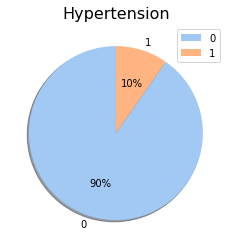

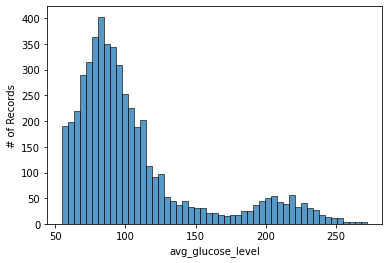

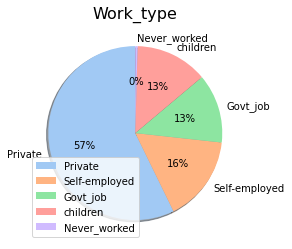

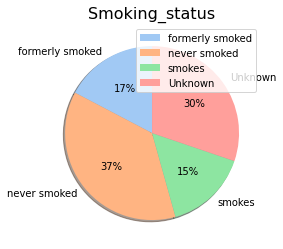

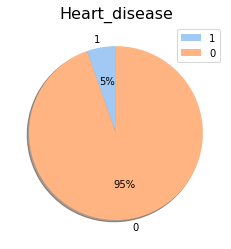

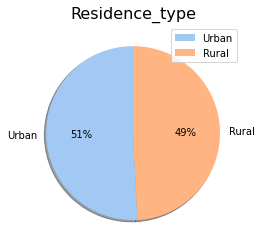

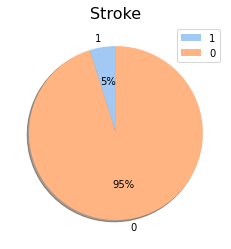

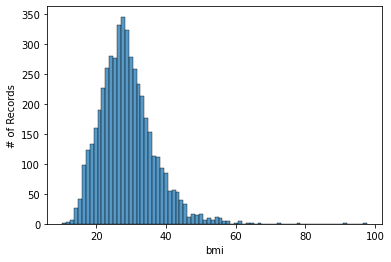

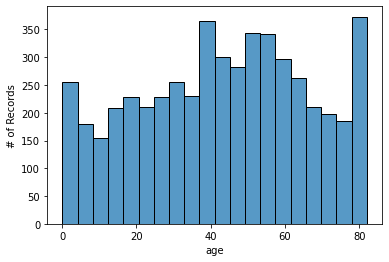

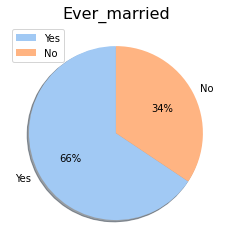

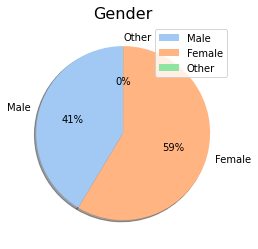

In [6]:
plotChartForAllDataset(strokeDataset,excludeList=['id'])

#### Important steps for data preprocessing
By looking at the data we would like to pin point some of our future steps of feature engineering and the reason for each one of them.

 - <b>Work type:</b> by looking at the unique values which assign to the work type column its clear that we are dealing with categorical variables that have no order or relationship. For that reason we will apply <u>one hot encoding</u> to that column during the preprocessing.

- <b>Gender:</b> even though the column hold 3 unique values samples with 'Other' assign to it are such a small portion from the dataset we will <u>discard all those samples and convert this column to binary values</u>

- <b>Ever married</b>: column with two unique values which will be converted to binary column. 1 for 'Yes' and 0 for 'No'

- <b>Residence type</b>: column with two unique values which will be converted to binary column. 1 for 'Urban' and 0 for 'Rural'

- <b>BMI</b>: The histogram suggest that there are some outliers with very hight BMI which goes out of the distribution. We will discard the top 1% do reduce the outlier influence
use this code to discard outlier

- <b>Stroke</b>: As it can be see in the chart the dataset is imbalanced which might effect our classifier performances.


### Water Quality dataset 

In [7]:
waterQualityDataset = pd.read_csv('datasets/classification/waterQuality.csv')
display(waterQualityDataset.info())
display(waterQualityDataset.describe())
display(waterQualityDataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


None

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


#### Feature explanation
1) pH value:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.

2) Hardness:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.

3) Solids (Total dissolved solids - TDS):
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.

4) Chloramines:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

5) Sulfate:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

6) Conductivity:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

7) Organic_carbon:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

8) Trihalomethanes:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.

9) Turbidity:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

10) Potability:
Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.

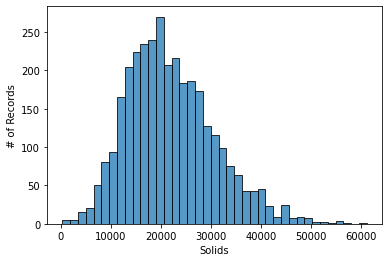

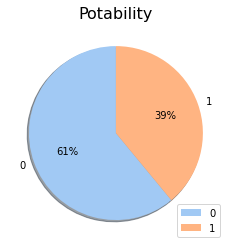

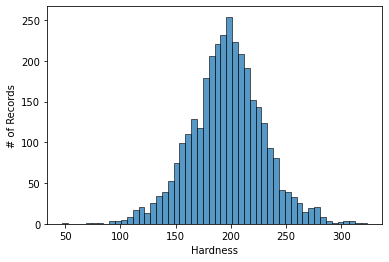

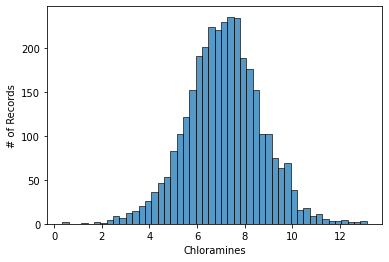

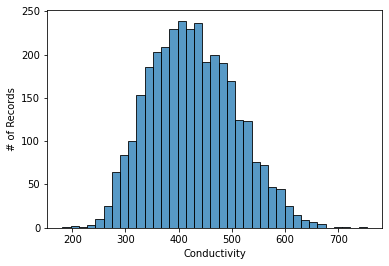

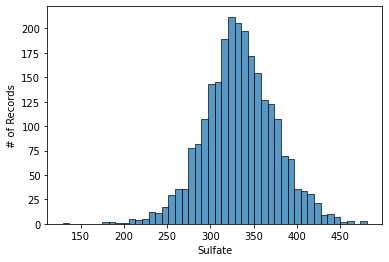

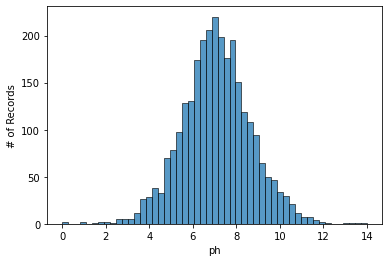

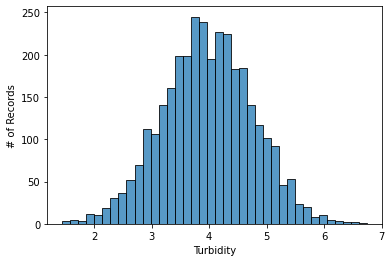

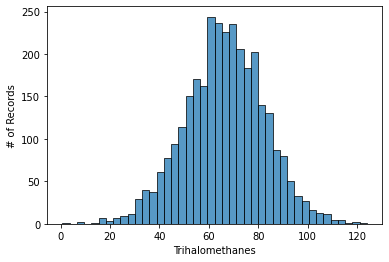

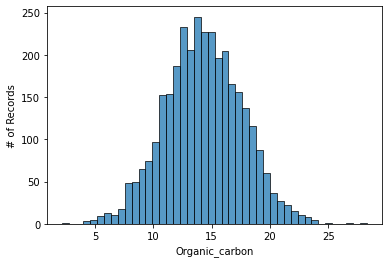

In [8]:
plotChartForAllDataset(waterQualityDataset)

### Crystal dataset 

In [9]:
crystalDataset = pd.read_csv('datasets/classification/crystal.csv')
display(crystalDataset.info())
display(crystalDataset.describe())
display(crystalDataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   v(A)               4165 non-null   int64  
 1   v(B)               4165 non-null   int64  
 2   r(AXII)(Å)         4165 non-null   float64
 3   r(AVI)(Å)          4165 non-null   float64
 4   r(BVI)(Å)          4165 non-null   float64
 5   EN(A)              4165 non-null   float64
 6   EN(B)              4165 non-null   float64
 7   l(A-O)(Å)          4165 non-null   float64
 8   l(B-O)(Å)          4165 non-null   float64
 9   ΔENR               4165 non-null   float64
 10  tG                 4165 non-null   float64
 11  τ                  4165 non-null   float64
 12  μ                  4165 non-null   float64
 13  Lowest distortion  4165 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 455.7+ KB


None

,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ
count,4165.000000,4165.000000,4165.00000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000
mean,0.882353,1.385114,1.00557,0.841789,0.801999,1.547309,1.599059,2.323011,2.017219,-2.186093,0.781040,1.332182,0.572857
std,1.672111,2.161707,0.33694,0.240549,0.234891,0.447277,0.442961,0.635699,0.555599,0.636470,0.135816,20.804362,0.167778
min,-1.000000,-1.000000,0.27000,0.270000,0.270000,0.790000,0.790000,0.000000,0.000000,-5.411536,0.384648,-480.827696,0.192857
25%,-1.000000,-1.000000,0.73000,0.670000,0.630000,1.200000,1.220000,2.294004,1.956808,-2.570036,0.680809,0.000000,0.450000
50%,0.000000,0.000000,0.98000,0.860000,0.760000,1.500000,1.600000,2.422517,2.075849,-2.084214,0.776944,0.000000,0.542857
75%,2.000000,3.000000,1.24000,0.960000,0.940000,1.910000,1.960000,2.582926,2.284156,-1.734643,0.873123,3.892903,0.671429
max,5.000000,5.000000,1.88000,1.670000,1.670000,2.540000,2.540000,3.300176,3.009747,-0.601714,1.321062,305.871348,1.192857


,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
0,0,0,0.52,0.52,0.93,2.18,2.54,2.214685,2.313698,-1.728214,0.582680,0.000000,0.664286,cubic
1,0,0,1.03,0.86,0.60,1.27,1.90,2.500930,0.000000,-1.768643,0.859135,0.000000,0.428571,cubic
2,2,4,0.92,0.67,0.53,1.83,1.88,2.290644,1.930311,-1.468464,0.849994,4.936558,0.378571,cubic
3,1,5,1.64,1.38,0.62,0.82,2.36,3.025719,1.745600,-1.974429,1.064161,3.977376,0.442857,orthorhombic
4,0,0,0.57,0.57,0.71,2.20,1.30,2.300109,2.027412,-1.622357,0.660190,0.000000,0.507143,cubic


#### Feature explanation
1) v(A) - Valence of A
2) v(B) - Valence of B
3) Radius A (r(A)) - ionic radius of A cation
4) Radius B (r(B)) - ionic radius of B cation
5) Electronegativity of A (EN(A)) - Average electronegativity value of A cation
6) Electronegativity of B (EN(B)) - Average electronegativity value of B cation
7) l(A-O) - Bond length of A-O pair
8) l(B-O) - Bond length of B-O pair
9) ΔENR - Electronegativity difference with radius
10) tG - Goldschmidt tolerance factor
11) τ New tolerance factor
12) μ - Octahedral factor
13) Lowest distortion - identifies it to be either a cubic, tetragonal, orthorhombic, and rhombohedral structure.

#### Important steps for data preprocessing

 - <b>τ:</b> We will discard outliers.
 - <b>Lowest distortion:</b> The target column will be converted to binary column which hold 'cubic' or 'non-cubic' values in order to convert this problem to binary one.



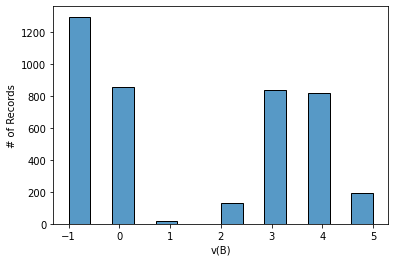

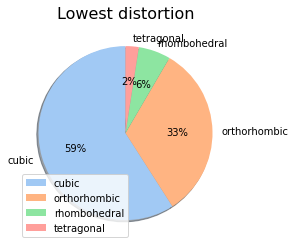

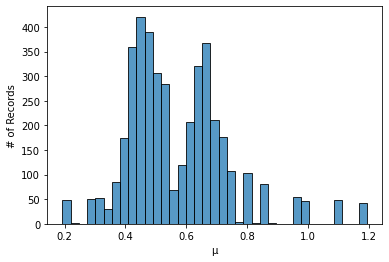

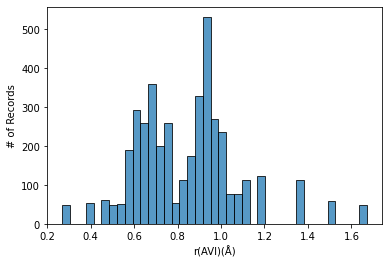

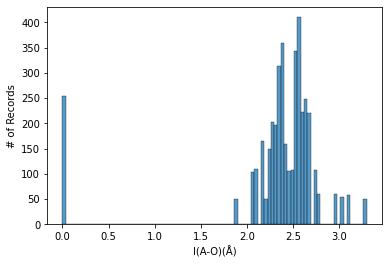

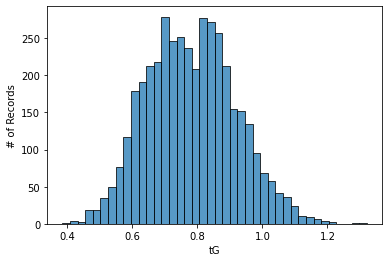

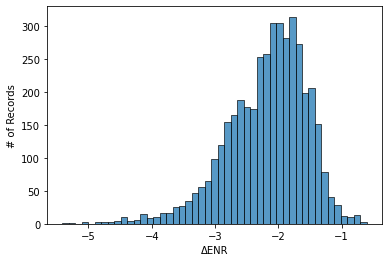

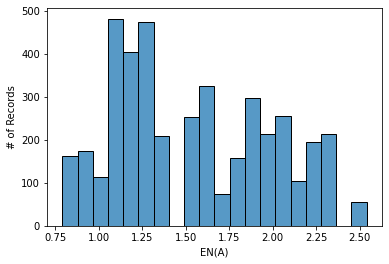

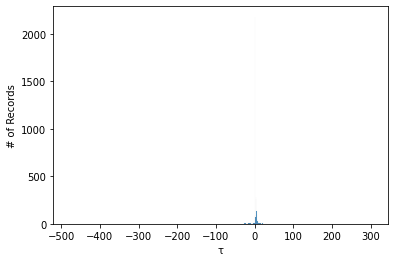

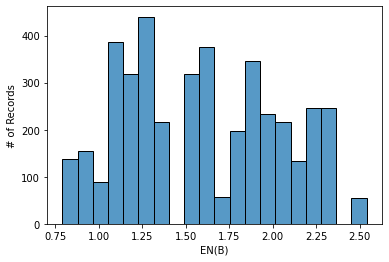

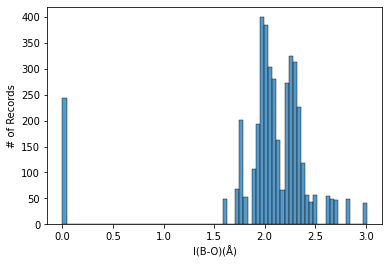

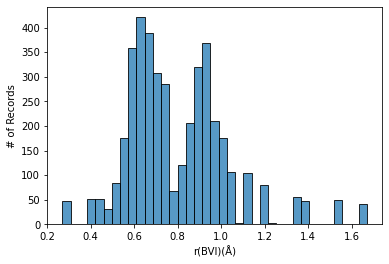

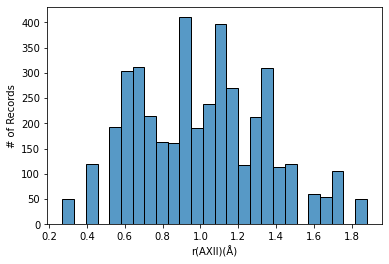

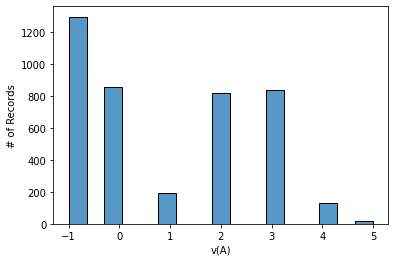

In [10]:
plotChartForAllDataset(crystalDataset)

### Wine Quality dataset

In [11]:
wineQualityDataset = pd.read_csv('datasets/classification/wineQuality.csv')
display(wineQualityDataset.info())
display(wineQualityDataset.describe())
display(wineQualityDataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


#### Feature explination
1) fixed acidity - Fixed acidity value
2) volatile acidity - Volatile acidity value
3) citric acid - Citric acid value
4) residual sugar - Residual sugar value
5) chlorides - Chlorides value
6) free sulfur dioxide - Free sulfur dioxide value
7) total sulfur dioxide - Total sulfur dioxide value
8) density - Density value
9) pH - pH value
10) sulphates - 
11) alcohol - alcohol rate
12) quality (score between 0 and 10)

#### Important steps for data preprocessing

 - <b>chlorides:</b> discarding outliers - top values.
 - <b>free sulfur dioxide:</b> discarding outliers - top values
 - <b>total sulfur dioxide:</b> discarding outliers - top values
 - <b>residual sugar:</b> discarding outliers - top values
 - <b>sulphates:</b> discarding outliers - top values
 - <b>quality:</b> We will convert this target column to binary values, therefor every sample with quality hight then 5 will be assign with 'High' value, all the other will be assign with 'Low'.


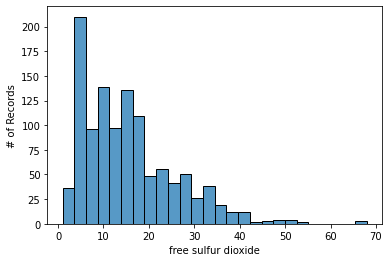

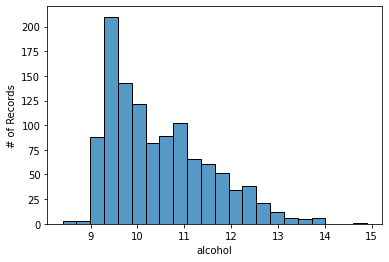

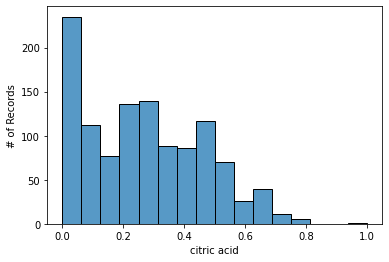

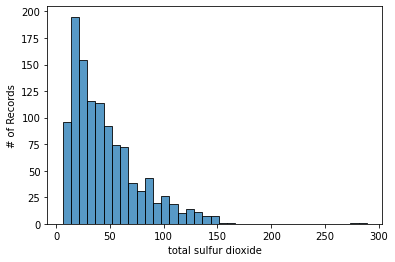

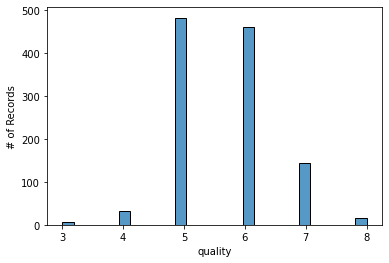

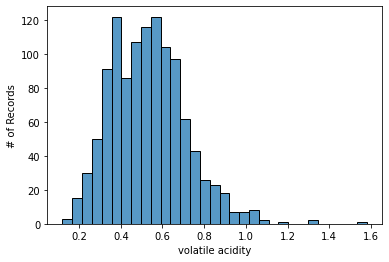

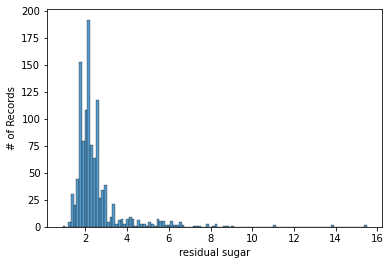

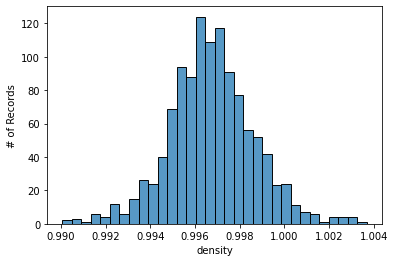

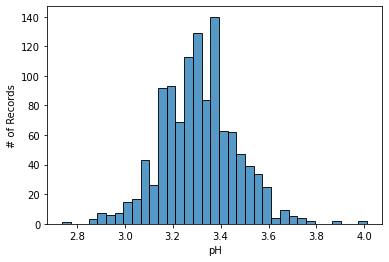

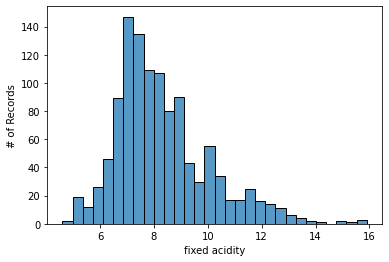

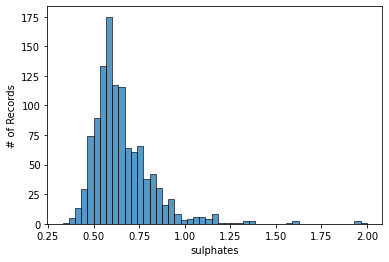

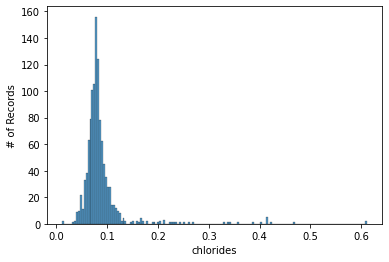

In [12]:
plotChartForAllDataset(wineQualityDataset,excludeList=["Id"])

### Adult Income dataset

In [13]:
adultIncomeDataset = pd.read_csv('datasets/classification/adult.csv')
display(adultIncomeDataset.info())
display(adultIncomeDataset.head())
display(adultIncomeDataset.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


#### Feature explanation
1) age: continuous.
2) workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
3) fnlwgt: continuous.
4) education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
4) education-num: continuous.
5) marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
6) occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
7) relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
8) race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
9) sex: Female, Male.
10) capital-gain: continuous.
11) capital-loss: continuous.
12) hours-per-week: continuous.
13) native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
14) target class: >50K, <=50K

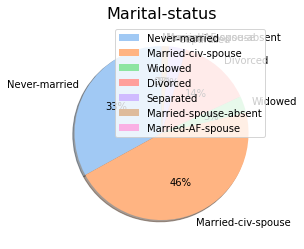

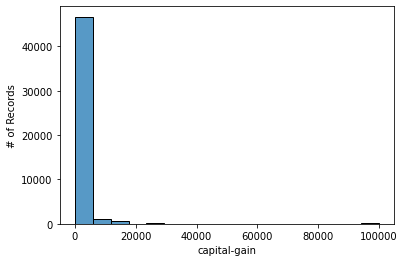

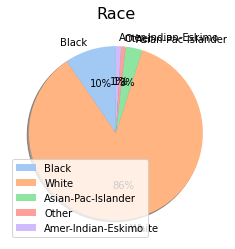

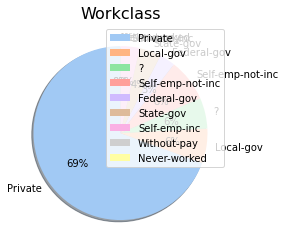

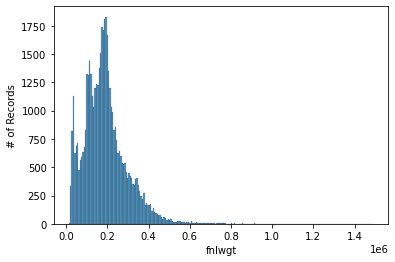

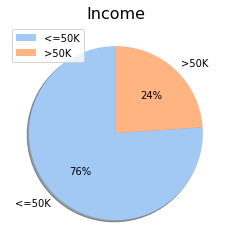

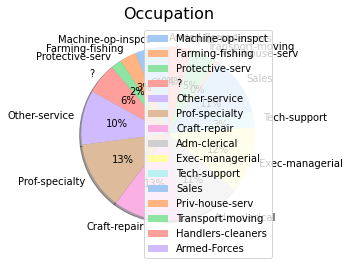

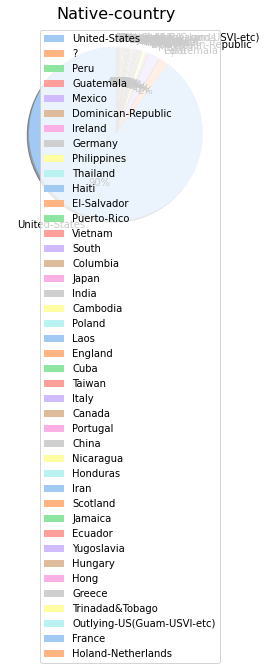

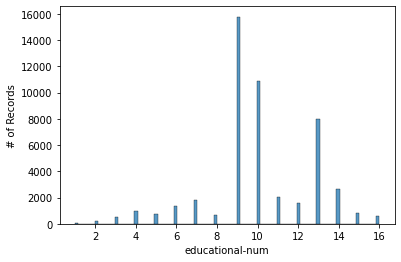

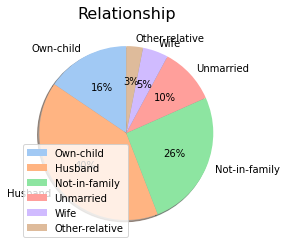

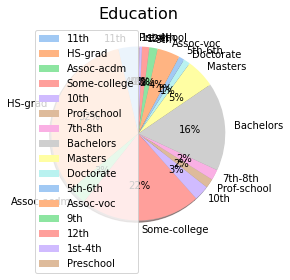

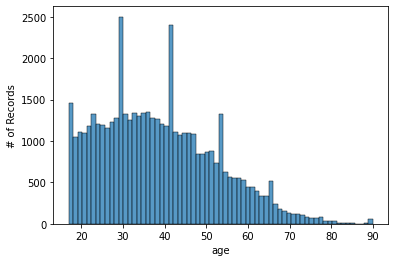

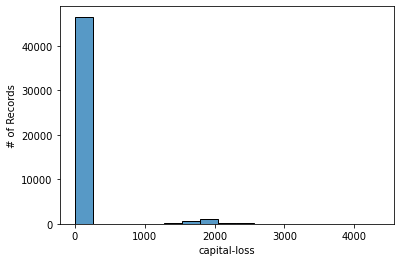

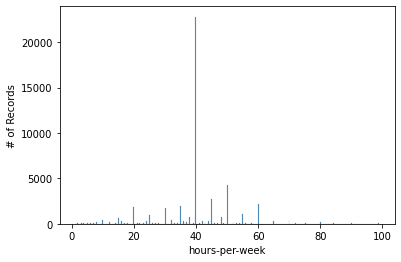

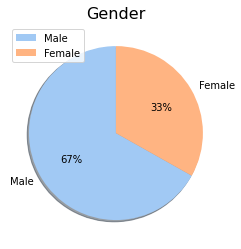

In [14]:
plotChartForAllDataset(adultIncomeDataset)

#### Important steps for data preprocessing

 - <b>Education:</b> The dataset comes with education-num column which is numeric label for the education, therefor we will use it instead.

 - <b>Race:</b> Categorical attribute which will be one hot encoded.

 - <b>Martial-status:</b> Categorical attribute which will be one hot encoded.
 - <b>Relationship:</b> Categorical attribute which will be one hot encoded.
 - <b>Native-country:</b> Categorical attribute which will be one hot encoded.
 - <b>Gender:</b> Categorical attribute which will be one hot encoded.
 - <b>Workclass:</b> Categorical attribute which will be one hot encoded.
 - <b>Occupation:</b> Categorical attribute which will be one hot encoded.

## Regression

In [98]:

waterQualityRateDataSet = pd.read_csv('datasets/regression/waterQuality.csv')
wineAlcoholDataSet = pd.read_csv('datasets/regression/wineQuality.csv')
dataLifeExpectancyDataSet = pd.read_csv('datasets/regression/data_life expectancy.csv')
strokeDataSet = pd.read_csv('datasets/regression/healthcare-dataset-stroke-data.csv')
housePriceDataSet = pd.read_csv('datasets/regression/house_data_price.csv')

### Wine Alcohol dataset

In [99]:
wineAlcoholDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [100]:
wineAlcoholDataSet.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [101]:
wineAlcoholDataSet.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


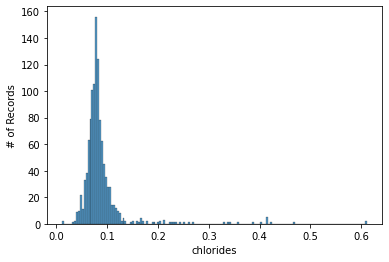

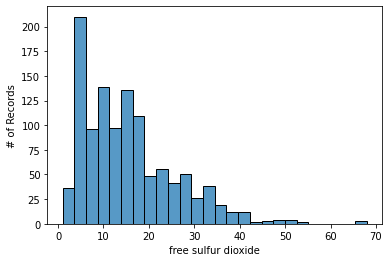

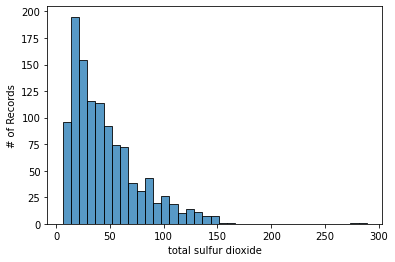

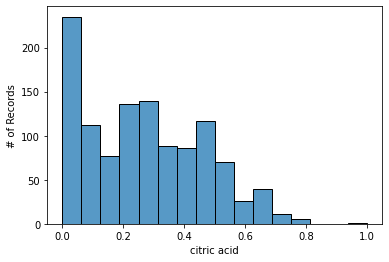

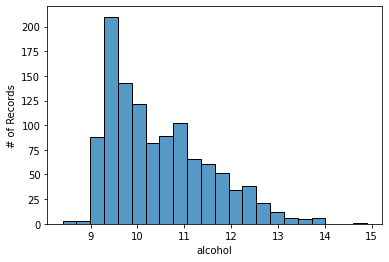

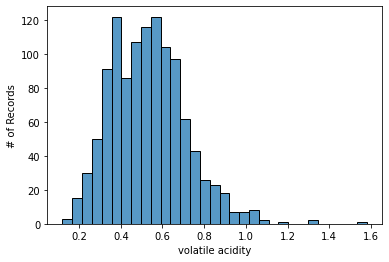

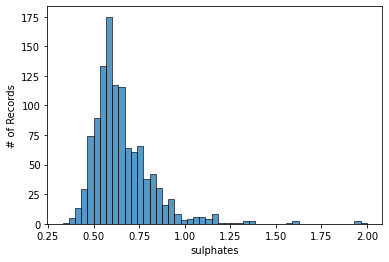

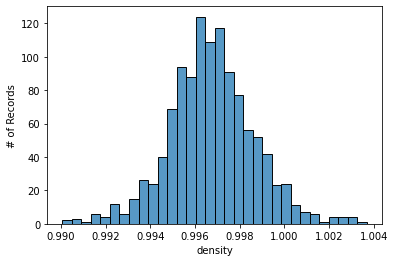

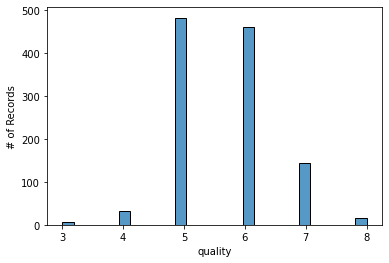

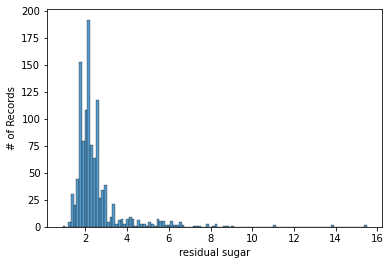

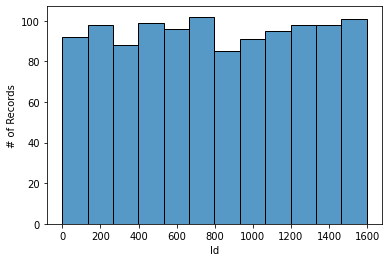

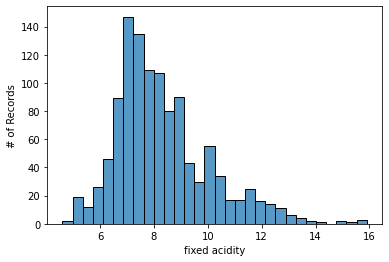

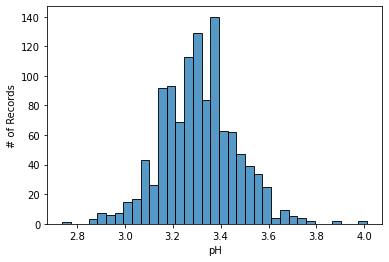

In [102]:
plotChartForAllDataset(wineAlcoholDataSet,excludeList=["id"])

### Life expectancy dataset

#### Feature explanation

In [20]:
dataLifeExpectancyDataSet.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [21]:
dataLifeExpectancyDataSet.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [22]:
dataLifeExpectancyDataSet.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


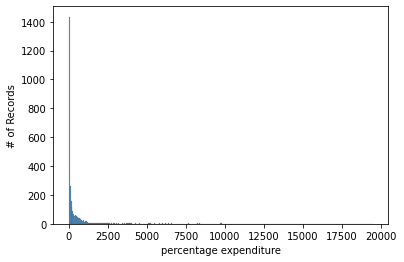

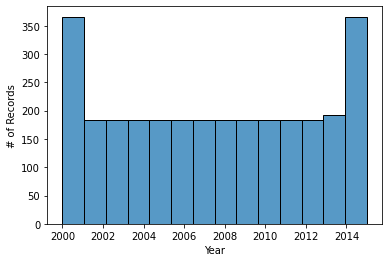

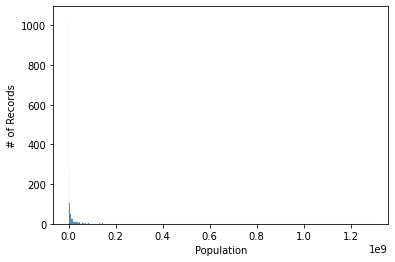

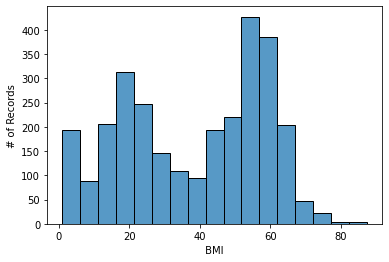

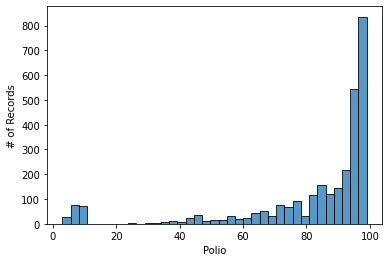

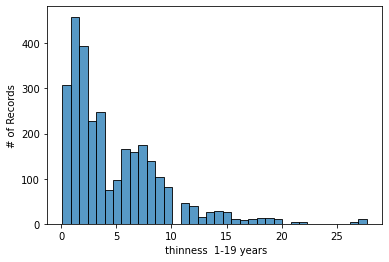

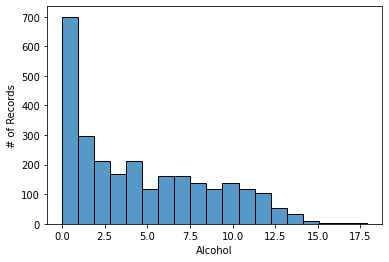

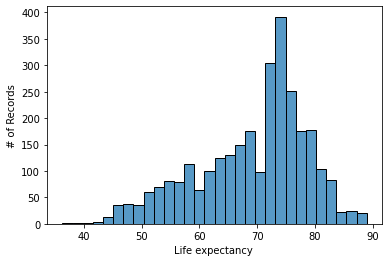

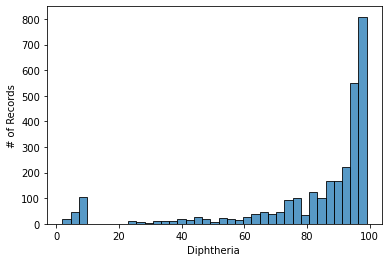

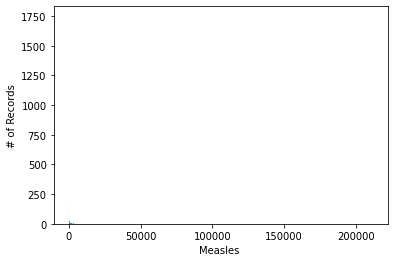

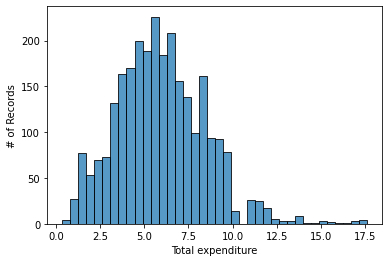

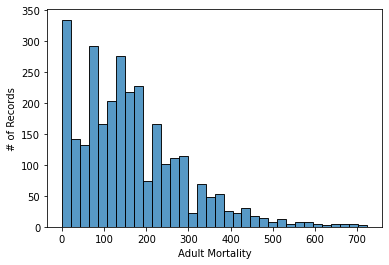

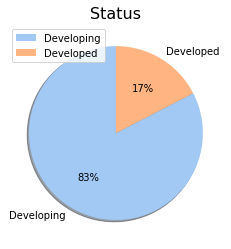

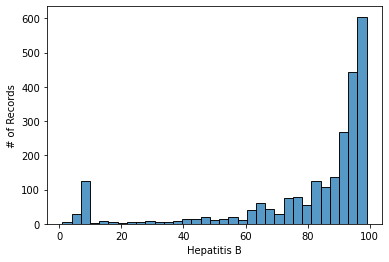

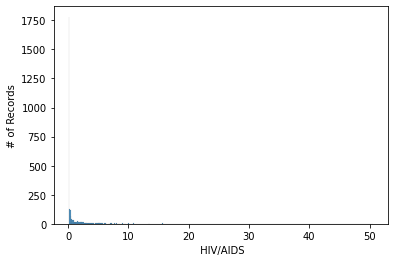

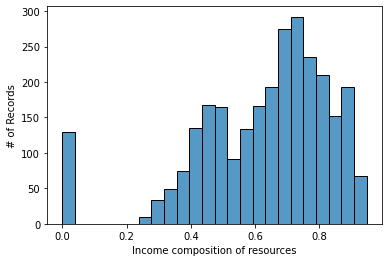

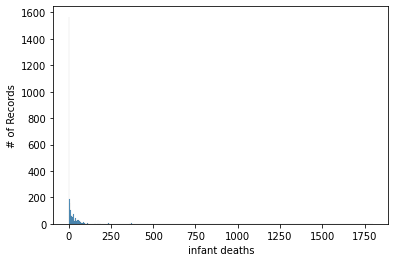

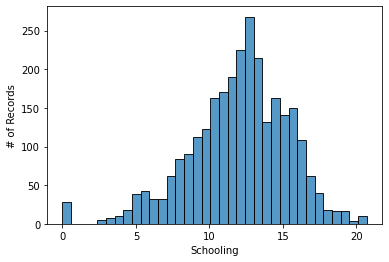

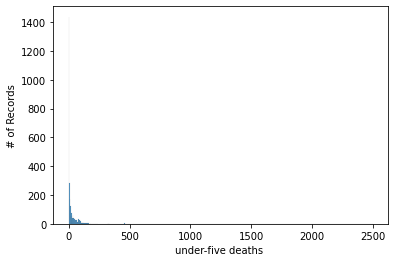

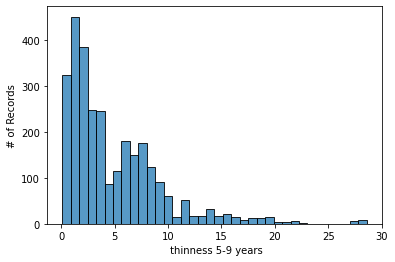

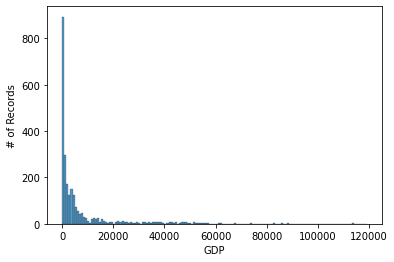

In [23]:
plotChartForAllDataset(dataLifeExpectancyDataSet,excludeList=["Country"])

### Healthcare stroke dataset

#### Feature explanation

In [24]:
strokeDataSet.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [25]:
strokeDataSet.describe()   

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [26]:
strokeDataSet.head()   

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


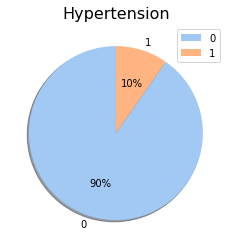

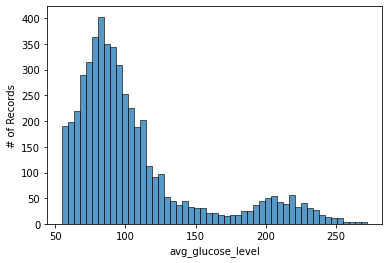

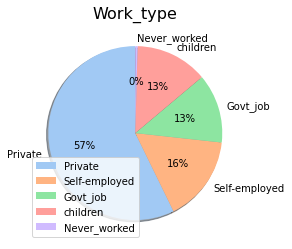

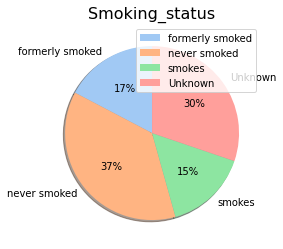

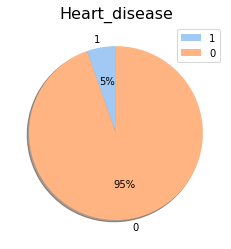

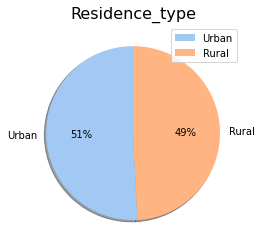

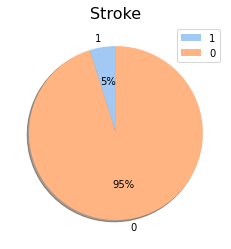

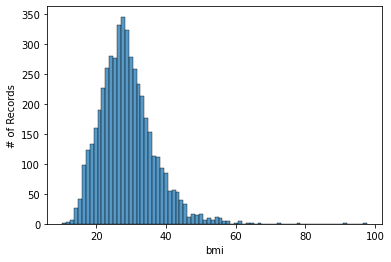

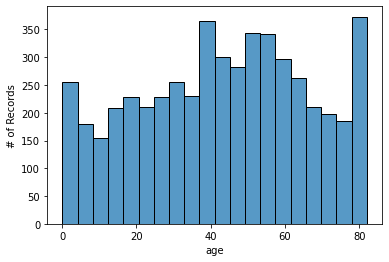

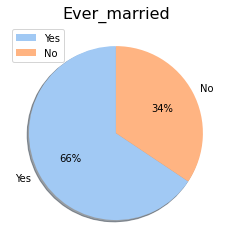

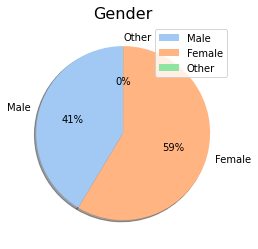

In [27]:
plotChartForAllDataset(strokeDataSet,excludeList=["id"])

### House price dataset

#### Feature explanation

In [28]:
housePriceDataSet.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [29]:
housePriceDataSet.describe()   

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [30]:
housePriceDataSet.head()   

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


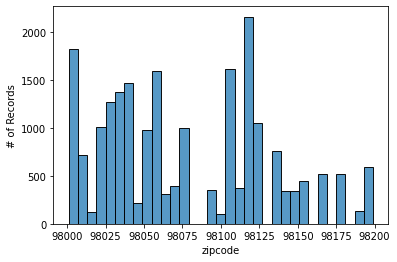

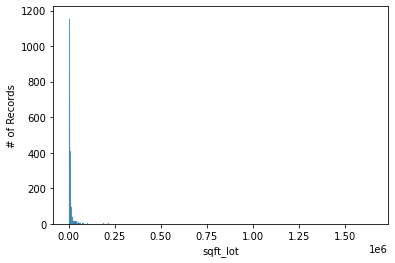

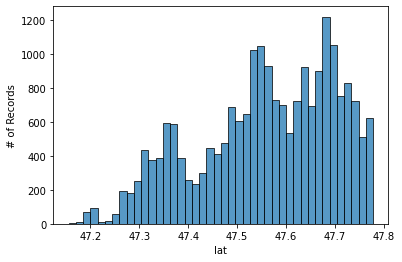

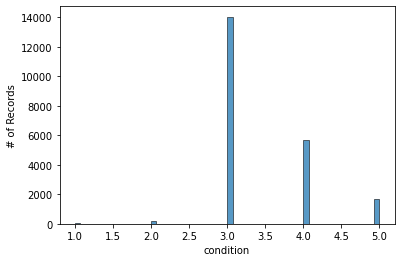

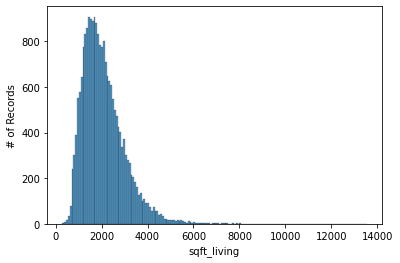

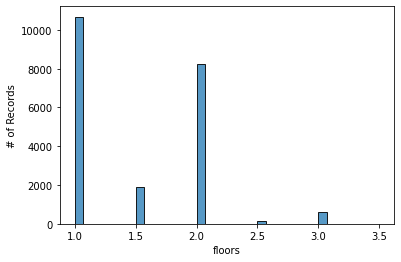

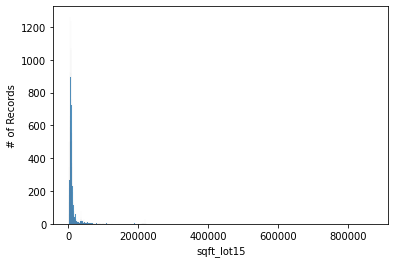

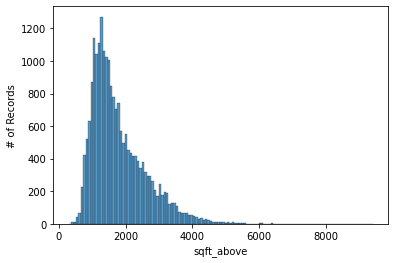

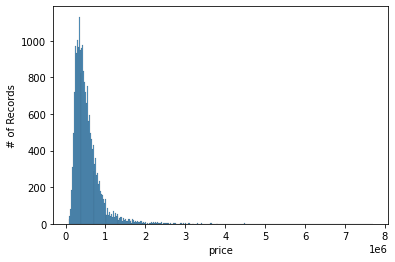

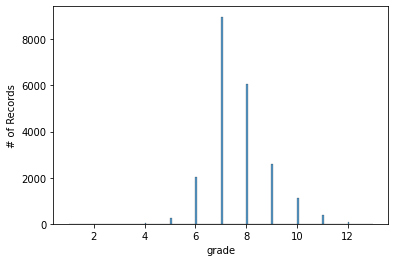

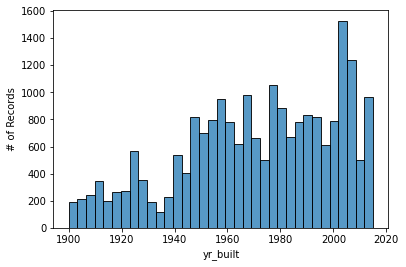

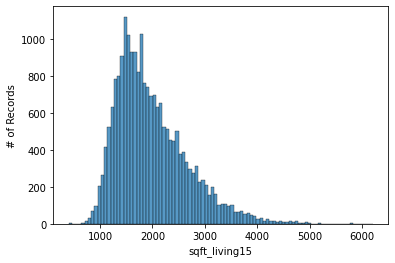

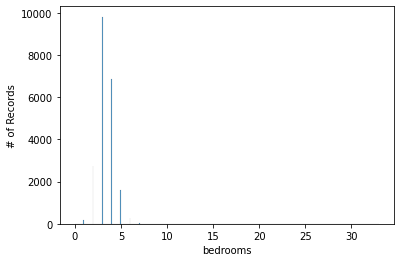

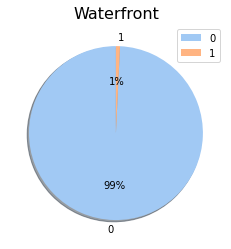

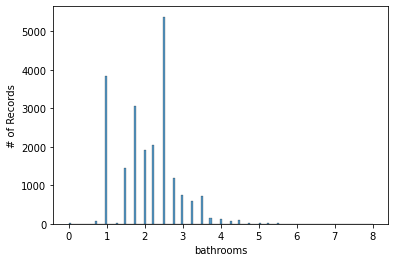

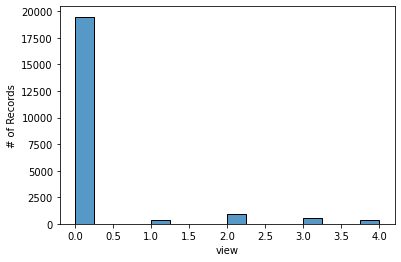

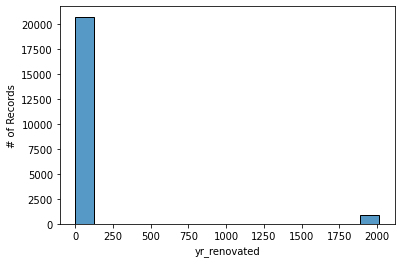

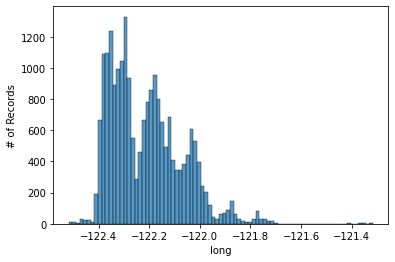

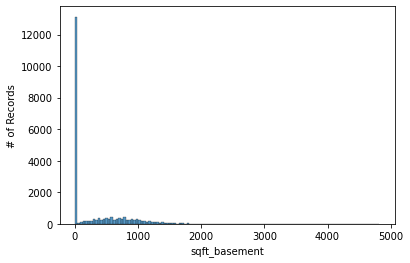

In [31]:
plotChartForAllDataset(housePriceDataSet,excludeList=["id", "date"])

### Water Quality (Hradness) death rate dataset

#### Feature explanation

In [78]:
waterQualityRateDataSet.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [79]:
waterQualityRateDataSet.describe()   

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# Model Evaluation

#### Util Functions

In [54]:
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# Utils
def preprocess(dataset):
    le = preprocessing.LabelEncoder()
    for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass
    dataset.fillna(dataset.mean(), inplace=True)
    return dataset

def evaluateModel(model, X, y, k=5, repeats=2):
    rkfcv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
    return cross_validate(estimator=model, scoring=['accuracy', 'roc_auc'], X=X, y=y, cv=rkfcv, n_jobs=-1)

def evaluateModel2(model, X, y, k=5, repeats=2):
    rkfcv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
    return cross_validate(estimator=model, scoring=['neg_mean_squared_error'], X=X, y=y, cv=rkfcv, n_jobs=-1)

def plotModelScore(scoresRegular, scoresSoftSplit,dataset_name ,title, metric):
    colors = sns.color_palette("Paired")
    plt.plot(scoresRegular[metric], label=f'regular classifier {title}', color=colors[0])
    plt.plot([scoresRegular[metric].mean() for x in scoresRegular[metric]], label=f'regular classifier {title} mean',
             color=colors[1], linewidth=0.5, marker="_")
    plt.plot(scoresSoftSplit[metric], label=f'soft split classifier {title}', color=colors[2])
    plt.plot([scoresSoftSplit[metric].mean() for x in scoresSoftSplit[metric]], label=f'soft split classifier {title} mean',
             color=colors[3], linewidth=0.5, marker="_")
    plt.legend()
    plt.title(f'{title.capitalize()} of models on {dataset_name.capitalize()}')
    plt.xlabel('Iteration')
    plt.ylabel(f'{title.capitalize()}')
    plt.show()

## Classifiers

### Healthcare Stroke dataset 

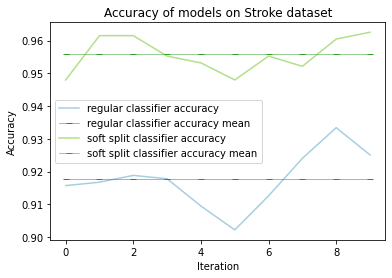

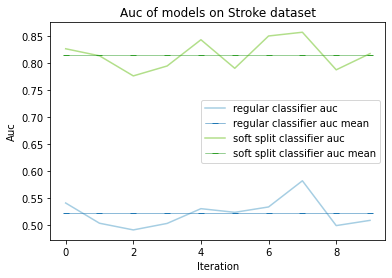

In [35]:
strokeDataset = pd.read_csv('datasets/classification/healthcare-dataset-stroke-data.csv')

#strokeDataset=preprocess(strokeDataset)

#Alternative preprocess using the future steps we mention earlier
strokeDataset=strokeDataset[(strokeDataset['bmi'] > strokeDataset['bmi'].quantile(0.01)) & (strokeDataset['bmi'] < strokeDataset['bmi'].quantile(0.99))]
strokeDataset = strokeDataset[strokeDataset['gender']!='Other']
strokeDataset=pd.get_dummies(strokeDataset,columns=['gender','work_type'],drop_first=False)
strokeDataset['ever_married'].replace({'Yes':1,'No':0},inplace=True)
strokeDataset['Residence_type'].replace({'Urban':1,'Rural':0},inplace=True)
strokeDataset['smoking_status'].replace({'never smoked':0,'formerly smoked':1,'smokes':2,'Unknown':3},inplace=True)
strokeDataset.fillna(strokeDataset.mean(), inplace=True)

X,y = strokeDataset.loc[:, strokeDataset.columns!='stroke'],strokeDataset['stroke']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Stroke dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Stroke dataset','auc','test_roc_auc')

#### Model performance analysis
Regarding the stroke dataset its clear that the soft split model out preform sklearn decision tree classifier on both accuracy and AUC.

#### Sensitivity Analysis
Attached is sensetivity graph of the stroke dataset by alpha and n:

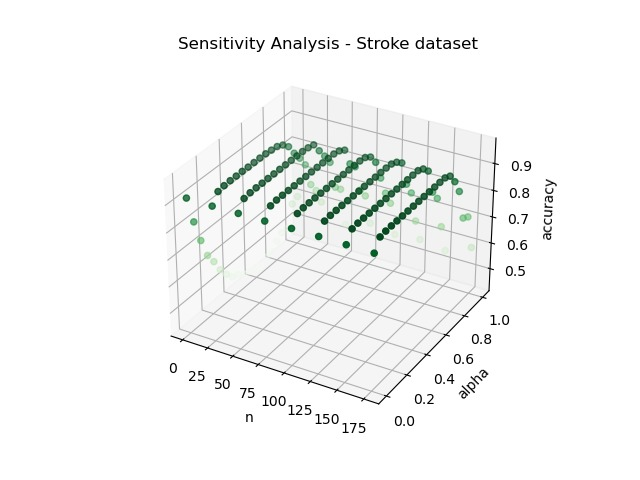

In [36]:
Image('datasets/Images/stroke.jpeg')

###  Water Quality dataset 

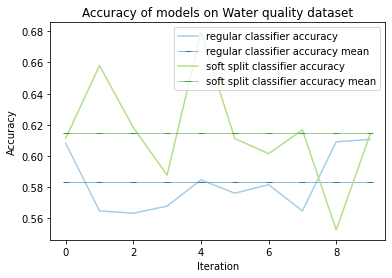

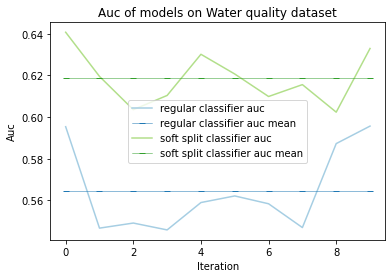

In [37]:
waterQualityDataset = pd.read_csv('datasets/classification/waterQuality.csv')
waterQualityDataset=preprocess(waterQualityDataset)
X,y = waterQualityDataset.loc[:, waterQualityDataset.columns!='Potability'],waterQualityDataset['Potability']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Water Quality dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Water Quality dataset','auc','test_roc_auc')

#### Model performance analysis
Regarding the water quality dataset the soft split technique is slightly better then the default sklearn implementation, but still gives a better result on both the AUC and accuracy.
Its important to note  that the classes are imbalanced, in favor of the potable records, which might be a reasonable explanation for both classifications' poor results

#### Sensitivity Analysis
Attached is sensetivity graph of the water quality dataset by alpha and n:

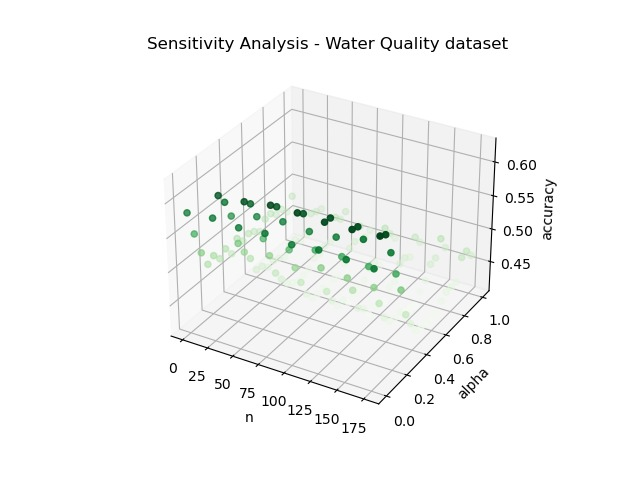

In [38]:
Image('datasets/Images/water q.jpeg')

### Crystal dataset

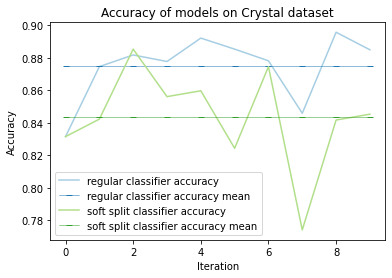

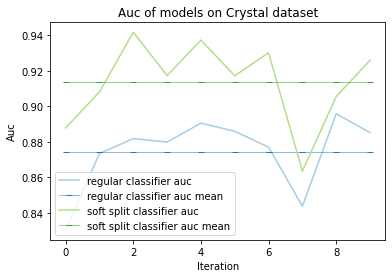

In [39]:
crystalDataset = pd.read_csv('datasets/classification/crystal.csv')
# We will convert this multi-class problem to binary problem. We will try to classify a samples to 'Cubic' or 'No cubic'
# By converting this to binary classification problem get better balanced dataset 
# and also we could measure our model performance using the AUC metric
# which can be apply only on binary classification problems.
crystalDataset=crystalDataset[(crystalDataset['τ'] > crystalDataset['τ'].quantile(0.15)) & (crystalDataset['τ'] < crystalDataset['τ'].quantile(0.95))]
crystalDataset['Lowest distortion'].mask(crystalDataset['Lowest distortion'] != 'cubic', 'no cubic', inplace=True)
X,y = crystalDataset.loc[:, crystalDataset.columns!='Lowest distortion'],crystalDataset['Lowest distortion']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Crystal dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Crystal dataset','auc','test_roc_auc')

#### Model performance analysis
The crystal dataset was puzzling for us. Out model did not outperform the Sklearn's implementation. Our initial thought was that binarized the target variable caused some anomalies which we did not intended to.
After long investigation we came out with another reason to explain the difference in the performance, but eventually it was disproved.

AUC-wise the soft split did increase the performance but along with the fact that it accuracy is inferior to the Sklearn's implementation this observation should be taken with caution.

#### Sensitivity Analysis
Attached is sensetivity graph of the crystal dataset by alpha and n:

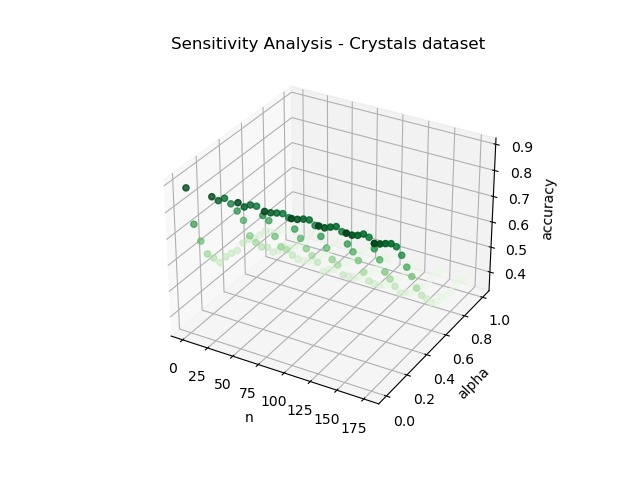

In [40]:
Image('datasets/Images/crystal.jpeg')

### Wine Quality dataset

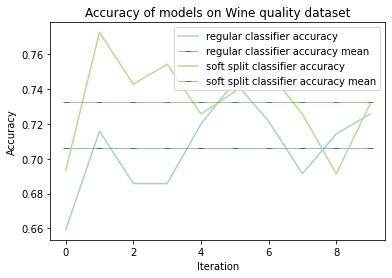

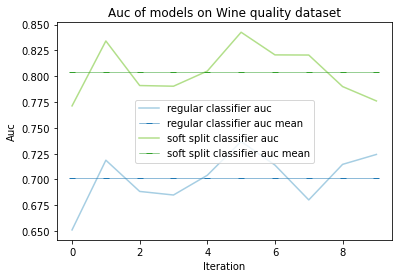

In [41]:
wineQualityDataset = pd.read_csv('datasets/classification/wineQuality.csv')
# We will convert this multi-class problem to binary problem. We will try to classify a samples to 'Low' or 'High'
# By converting this to binary classification problem get better balanced dataset 
# and also we could measure our model performance using the AUC metric
wineQualityDataset=wineQualityDataset[wineQualityDataset['chlorides'] < wineQualityDataset['chlorides'].quantile(0.95)]
wineQualityDataset=wineQualityDataset[wineQualityDataset['free sulfur dioxide'] < wineQualityDataset['free sulfur dioxide'].quantile(0.95)]
wineQualityDataset=wineQualityDataset[wineQualityDataset['total sulfur dioxide'] < wineQualityDataset['total sulfur dioxide'].quantile(0.95)]
wineQualityDataset=wineQualityDataset[wineQualityDataset['residual sugar'] < wineQualityDataset['residual sugar'].quantile(0.95)]
wineQualityDataset=wineQualityDataset[wineQualityDataset['sulphates'] < wineQualityDataset['sulphates'].quantile(0.95)]
wineQualityDataset['quality'].mask(wineQualityDataset['quality'] <= 5, 0, inplace=True)
wineQualityDataset['quality'].mask(wineQualityDataset['quality'] > 5, 1, inplace=True)
wineQualityDataset['quality'].mask(wineQualityDataset['quality'] == 0, 'Low', inplace=True)
wineQualityDataset['quality'].mask(wineQualityDataset['quality'] == 1, 'High', inplace=True)

X,y = wineQualityDataset.loc[:, wineQualityDataset.columns!='quality'],wineQualityDataset['quality']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Wine Quality dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Wine Quality dataset','auc','test_roc_auc')

#### Model performance analysis
As we can observe Our soft split model's performance are slightly better then the Sklearn classifier accuracy.
Regarding thr AUC score we observed major improvement.

#### Sensitivity Analysis
Attached is sensetivity graph of the wine quality dataset by alpha and n:

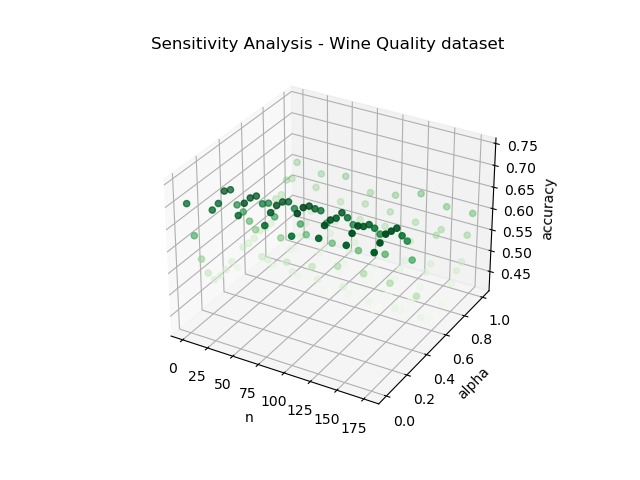

In [42]:
Image('datasets/Images/wine q.jpeg')

### Adult Income dataset

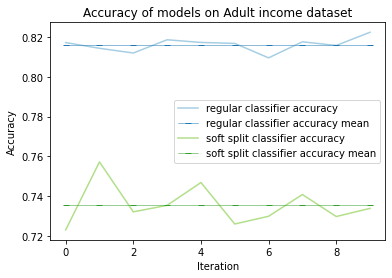

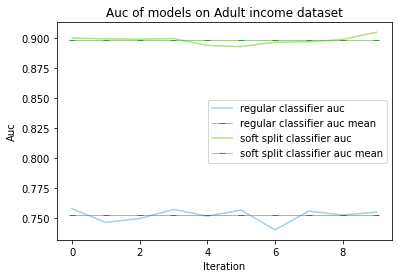

In [43]:
#CAUTION: this fitting process will take longer then other

adultIncomeDataset = pd.read_csv('datasets/classification/adult.csv')
adultIncomeDataset.drop(columns='education',inplace=True)

adultIncomeDataset=pd.get_dummies(adultIncomeDataset,columns=['race','marital-status','relationship','native-country','gender','workclass','occupation'],drop_first=False)

X,y = adultIncomeDataset.loc[:, adultIncomeDataset.columns!='income'],adultIncomeDataset['income']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Adult Income dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Adult Income dataset','auc','test_roc_auc')

#### Model performance analysis
As we can observe Our soft split model's performance are less better then the Sklearn classifier accuracy.
Regarding thr AUC score we observed major improvement.

#### Sensitivity Analysis
Attached is sensetivity graph of the adult income dataset by alpha and n:

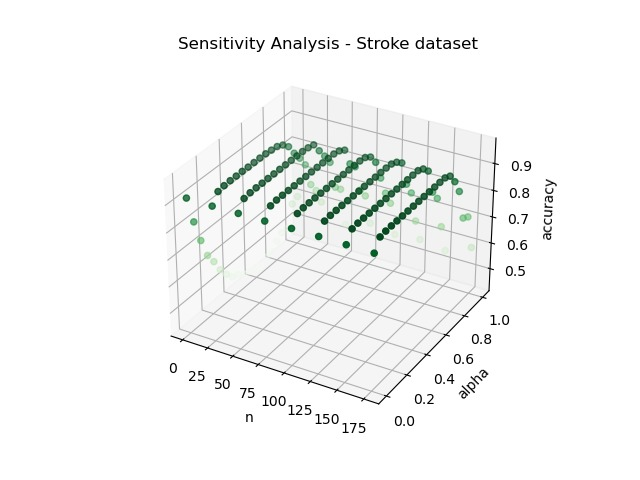

In [44]:
Image('datasets/Images/stroke.jpeg')

### Sensitivity Analysis for all the 5 classification models

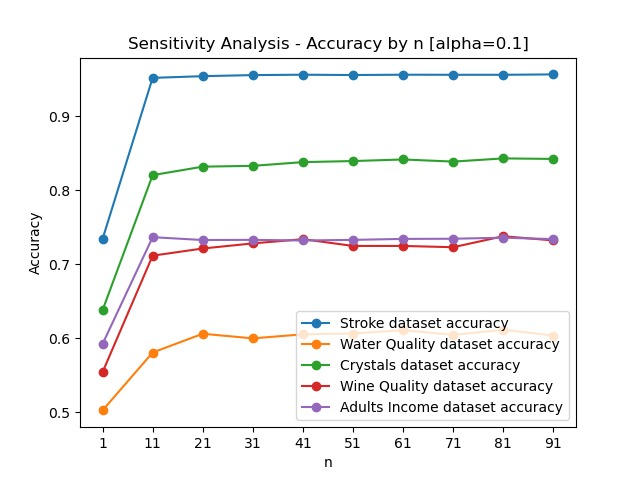

In [45]:
Image('datasets/Images/hist1.jpeg')

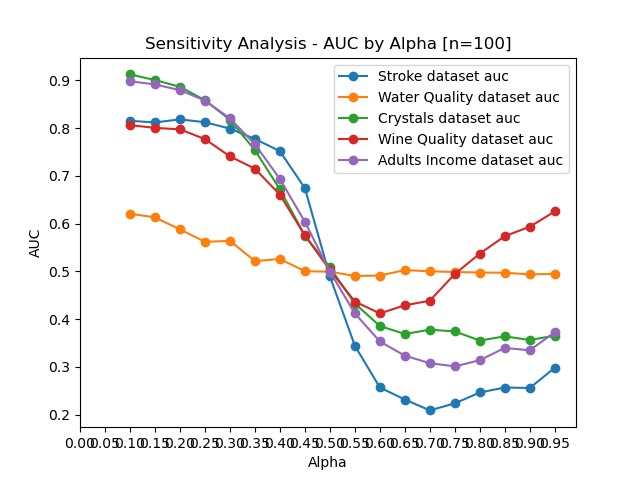

In [46]:
Image('datasets/Images/hist2.jpeg')

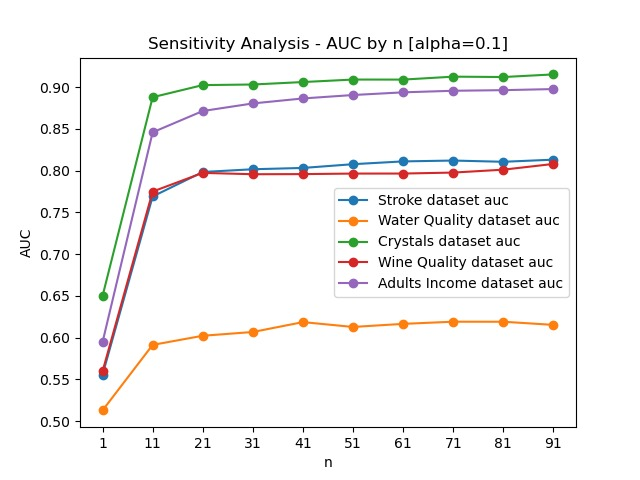

In [47]:
Image('datasets/Images/hist3.jpeg')

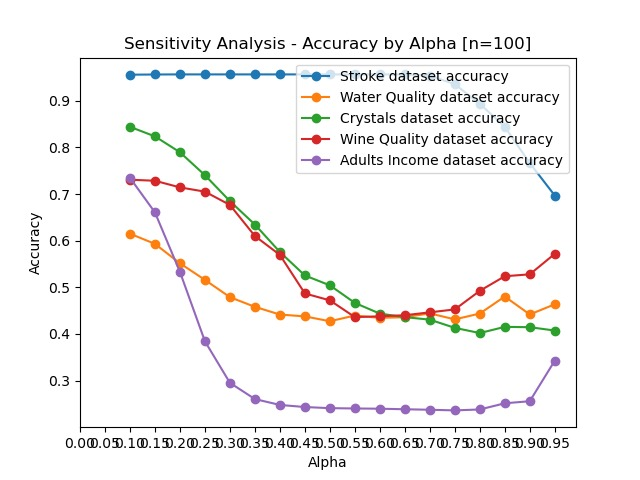

In [48]:
Image('datasets/Images/hist4.jpeg')

## Regressors

### Wine Alcohol dataset 

/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


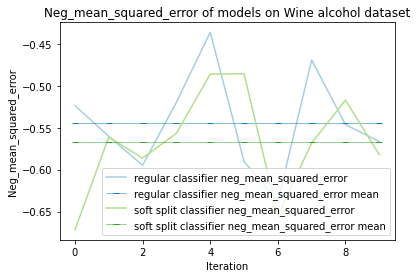

In [103]:
wineAlcoholDataSet = pd.read_csv('datasets/regression/wineQuality.csv')
X,y = wineAlcoholDataSet.loc[:, (wineAlcoholDataSet.columns!='id')&(wineAlcoholDataSet.columns!='alcohol')],wineAlcoholDataSet['alcohol']

treeRegressor = DecisionTreeRegressor()
treeSoftSplitRegressor = SoftSplitDecisionTreeRegressor(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel2(treeRegressor,X,y)
scoresSoftSplit =evaluateModel2(treeSoftSplitRegressor,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Wine Alcohol dataset','neg_mean_squared_error','test_neg_mean_squared_error')

### Life expectancy dataset 

/var/folders/cq/ln4dlqfj4png9mstnc6n0mc00000gq/T/ipykernel_89358/1879261576.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataLifeExpectancyDataSet.fillna(dataLifeExpectancyDataSet.mean(), inplace=True)
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' 

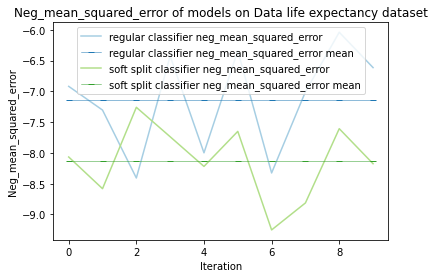

In [55]:
dataLifeExpectancyDataSet = pd.read_csv('datasets/regression/data_life expectancy.csv')

dataLifeExpectancyDataSet['Status'].replace({'Developing':0,'Developed':1},inplace=True)
dataLifeExpectancyDataSet.fillna(dataLifeExpectancyDataSet.mean(), inplace=True)
X,y = dataLifeExpectancyDataSet.loc[:, (dataLifeExpectancyDataSet.columns!='Country')&(dataLifeExpectancyDataSet.columns!='Life expectancy ')],dataLifeExpectancyDataSet['Life expectancy ']

treeRegressor = DecisionTreeRegressor()
treeSoftSplitRegressor = SoftSplitDecisionTreeRegressor(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel2(treeRegressor,X,y)
scoresSoftSplit =evaluateModel2(treeSoftSplitRegressor,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','neg_mean_squared_error','test_neg_mean_squared_error')
#plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','accuracy','test_accuracy')

### Healthcare Stroke dataset 

/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


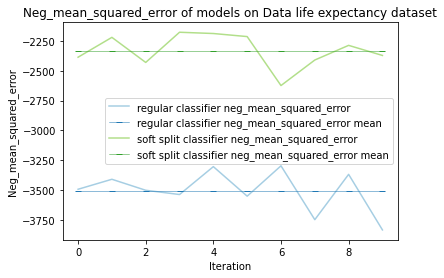

In [57]:
strokeDataset = pd.read_csv('datasets/regression/healthcare-dataset-stroke-data.csv')

strokeDataset=strokeDataset[(strokeDataset['bmi'] > strokeDataset['bmi'].quantile(0.01)) & (strokeDataset['bmi'] < strokeDataset['bmi'].quantile(0.99))]
strokeDataset = strokeDataset[strokeDataset['gender']!='Other']
strokeDataset=pd.get_dummies(strokeDataset,columns=['gender','work_type'],drop_first=False)
strokeDataset['ever_married'].replace({'Yes':1,'No':0},inplace=True)
strokeDataset['Residence_type'].replace({'Urban':1,'Rural':0},inplace=True)
strokeDataset['smoking_status'].replace({'never smoked':0,'formerly smoked':1,'smokes':2,'Unknown':3},inplace=True)
strokeDataset.fillna(strokeDataset.mean(), inplace=True)

X,y = strokeDataset.loc[:, strokeDataset.columns!='avg_glucose_level'],strokeDataset['avg_glucose_level']

treeRegressor = DecisionTreeRegressor()
treeSoftSplitRegressor = SoftSplitDecisionTreeRegressor(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel2(treeRegressor,X,y)
scoresSoftSplit =evaluateModel2(treeSoftSplitRegressor,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','neg_mean_squared_error','test_neg_mean_squared_error')
#plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','accuracy','test_accuracy')

### House price dataset 

/var/folders/cq/ln4dlqfj4png9mstnc6n0mc00000gq/T/ipykernel_89358/3644346985.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housePriceDataSet.fillna(housePriceDataSet.mean(), inplace=True)
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated i

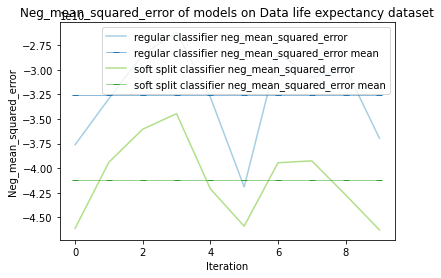

In [60]:
housePriceDataSet = pd.read_csv('datasets/regression/house_data_price.csv')

housePriceDataSet.fillna(housePriceDataSet.mean(), inplace=True)
X,y = housePriceDataSet.loc[:, (housePriceDataSet.columns!='price')&(housePriceDataSet.columns!='date')],housePriceDataSet['price']

treeRegressor = DecisionTreeRegressor()
treeSoftSplitRegressor = SoftSplitDecisionTreeRegressor(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel2(treeRegressor,X,y)
scoresSoftSplit =evaluateModel2(treeSoftSplitRegressor,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','neg_mean_squared_error','test_neg_mean_squared_error')
#plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','accuracy','test_accuracy')

### Water Hardness dataset 

/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/eshmueli/Library/Python/3.8/lib/python/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


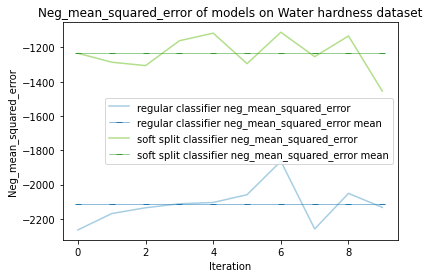

In [104]:
waterHardnessDataSet = pd.read_csv('datasets/regression/waterQuality.csv')

waterHardnessDataSet.fillna(waterHardnessDataSet.mean(), inplace=True)
X,y = waterHardnessDataSet.loc[:, waterHardnessDataSet.columns!='Hardness'],waterHardnessDataSet['Hardness']

treeRegressor = DecisionTreeRegressor()
treeSoftSplitRegressor = SoftSplitDecisionTreeRegressor(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel2(treeRegressor,X,y)
scoresSoftSplit =evaluateModel2(treeSoftSplitRegressor,X.values,y)
plotModelScore(scoresRegular, scoresSoftSplit,'water hardness dataset','neg_mean_squared_error','test_neg_mean_squared_error')
#plotModelScore(scoresRegular, scoresSoftSplit,'Data Life Expectancy dataset','accuracy','test_accuracy')

### Sensitivity Analysis for all the 5 regression models

# Soft Split optimization
### Motivation

The main problem with the soft split technique is that its not take into account how close the sample value is to the threshold.
In Future details, we would like that when the sample value is close be less then `delta` the alpha will be low.
for example. when the sample value equals the threshold we would like to achieve alpha=0.5 and as we get far from the threshold the alpha will raise agaxin until reaching (1-alpha).

By applying this method we achieve looseness around the threshold but maintain the soft split behavior.

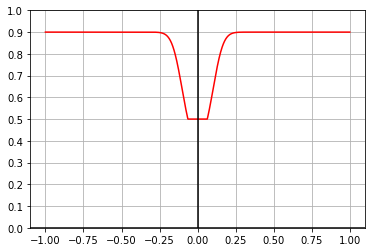

In [10]:
def calcSigmoid(x,alphaProbability=0.1,nearSensitivity=10**2):
    return [max(0.5, x) for x in ((1 / (1 + np.exp(-nearSensitivity * (x ** 2)))) - alphaProbability)]

x = np.linspace(-1, 1, 1000)
plt.plot(x, calcSigmoid(x), color='red')
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

The `calcSigmoid` function can be configure using two parameters.
The first one `alphaProbability` is the same alpha we provide to the model and use to maintain the soft split behavior when the distance to the threshold exceed some `delta`

The second parameter `nearSensitivity` controls the `delta` or in other words it's controls how close to the threshold we would loose the alpha

### Challenges

Due to the distance-base approach of the algorithm we have to apply feature scaling.
The different dataset contains features that highly vary in magnitudes, units, and range, thus scaling we should like to scale all the data features in the range [0, 1] 
The algorithms which use Euclidean Distance measures are sensitive to Magnitudes. Here feature scaling helps to weigh all the features equally.

Therefor in the model evaluation step we will use `MinMaxScaler` in order to achieve uniform range between all the features